In [19]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Theorical Framework 

#### Kullback-Leibler divergence 

The Kullback-Leibler divergence between $P, K \in \mathbb{R}_+^{n \times m}$ is
$$ \text{KL}(P || K) := \sum_{i,j} P_{i,j} \left[ \text{log} ( \frac{P_{i,j}}{K_{i,j}})  - 1 \right]. $$

Given a convex set $C \subset \mathbb{R}^N$, the projection according to the Kullback-Leiber divergence is defined as : $$ \text{Proj} _C ^{KL} ( \nu ) = \operatorname*{argmin} _{ \pi \in C } \text{KL}(\pi || \nu). $$

#### Entropic Regularization of Optimal Transport


We consider two input histograms $a,b \in \Sigma _n$, where we denote the simplex in $\mathbb{R}^n $ : $ \Sigma _n := \{ a \in \mathbb{R} _+ ^n, \text{  } \sum_i a_i = 1 \}.  $


We consider the following discrete regularized transport
$$  W_\epsilon(a,b) := \operatorname*{min} _{P \in U(a,b)} <C, P> - \epsilon E(P).  $$
where the polytope of coupling is defined as
$$ U(a,b) := \{P \in (\mathbb{R}^+)^{n \times m}, \text{  } P \textbf{1}_m = a, \text{  } P^T \textbf{1}_n = b \},  $$
where $\textbf{1} _n := (1,... ,1)^T \in \mathbb{R}^n $,
and for $P \in \mathbb{R}_+^{n \times m}$, we define its entropy as
$$ E(P) := - \sum_{i,j} P_{i,j} \log(P_{i,j}) . $$


Remark : When $\epsilon=0$ one recovers the classical (discrete) optimal transport.


Here the matrix $C \in (\mathbb{R}^+)^{n \times m} $ defines the ground cost, i.e.
$C_{i,j}$ is the cost of moving mass from a bin indexed by $i$ to a bin indexed by $j$.


The regularized transportation problem can be re-written as a projection
$$ W_\epsilon(a,b) = \epsilon \operatorname*{min}_{P \in U(a,b)} \text{KL} (P || K) \text{ where } K_{i,j} := e^{ -\frac{C_{i,j}}{\epsilon} }  $$
of the Gibbs kernel $K$ according to the Kullback-Leibler divergence.

#### Sinkhorn Algorithm

1. **Inputs**: Cost matrix $C \in \mathbb{R}^{n \times n}$, scalar $\epsilon > 0$, iterations $N$
2. **Initialize** $u = \mathbf{1}_n$, $v = \mathbf{1}_n$ (all ones)
3. **Loop** for $k = 1$ to $N$:
    - Update $u \leftarrow \frac{\mathbf{a}}{K v}$ where $K = \exp\left(-\frac{C}{\epsilon}\right)$
    - Update $v \leftarrow \frac{\mathbf{b}}{K^T u}$
4. **Return** $\gamma = \operatorname{diag}(u) \cdot K \cdot \operatorname{diag}(v)$



# Load the data (MNIST dataset)

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset = datasets.MNIST(root = './data', train = True, download = True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

# Download and load the test data
testset = datasets.MNIST(root='./data', train=False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:12<00:00, 810226.89it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 142144.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 574710.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5001451.50it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [16]:
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

In [15]:
len(trainset)

60000

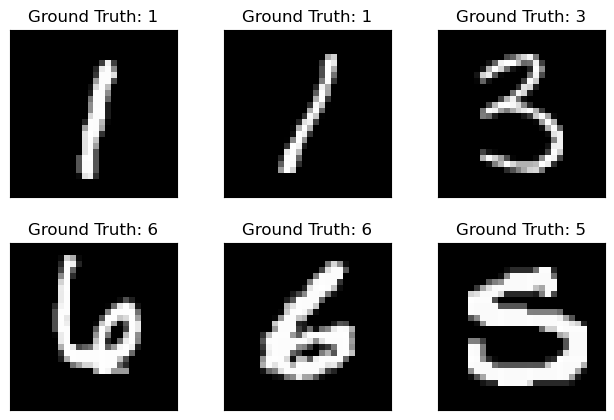

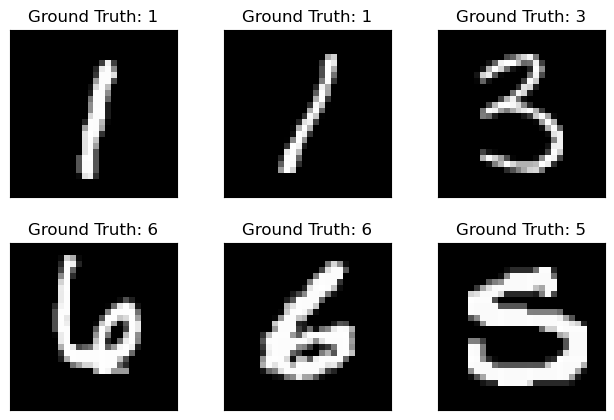

In [17]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap = 'gray', interpolation = 'none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Additional : Training a Neural Network 

In [20]:
# Define the network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [52]:
# Initialize the network and the optimizer
learning_rate = 0.01
momentum = 0.5
n_epochs = 5
log_interval = 10

network = Net()
optimizer = optim.SGD(network.parameters(), 
                      lr = learning_rate,
                      momentum = momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(trainloader.dataset) for i in range(n_epochs + 1)]

In [26]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(trainloader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(trainloader.dataset),
        100. * batch_idx / len(trainloader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))

In [27]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in testloader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(testloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))

In [53]:
test()
for epoch in range(n_epochs):
  train(epoch)
  test()

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_5358/322522677.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3052, Accuracy: 1013/10000 (10%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.312728
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.316224
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.311128
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.305479
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.300514
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.306728
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.292247
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.298019
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.287896
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.301484
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.286542
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.280757
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.284503
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.262282
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.277527
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.263414
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.276292
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.248730
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.244312
Train Epoch: 0 [12160

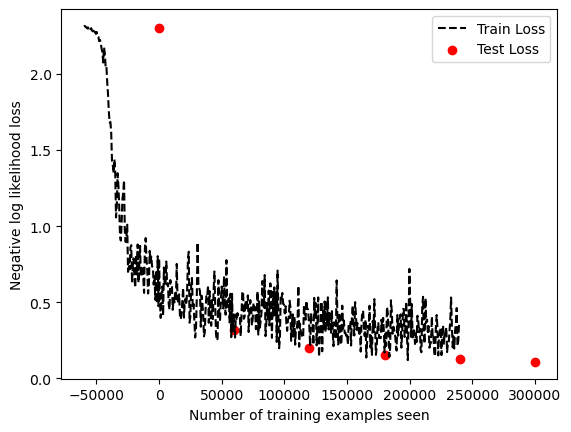

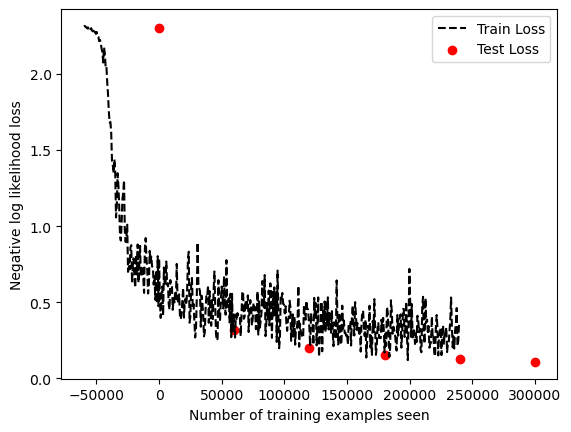

In [54]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color = 'black', linestyle = '--')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('Negative log likelihood loss')
fig

In [51]:
test_losses

[2.3062525917053223,
 0.3403142178297043,
 0.20199349054694177,
 0.1496059831261635,
 0.11959661065489054,
 0.10635441104508936,
 0.10085348697379232,
 0.10085348697379232,
 0.08949565773755312,
 0.0836478594545275,
 0.0802489285543561,
 0.07579540116228163,
 0.07068696762891487]